In [1]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [9.0, 6.0]

# Session 1: Text Analysis Overview 
**May 31, 2018**

In this session, we will explore the basics of applying linguistic and grammatical tools to the statistical and contextual analysis of text documents, often the preliminary steps to building text analytics models. We will discuss the creation and maintenance of a corpus, a dataset composed of text documents, and the techniques to preprocess text into units of discourse - paragraphs, sentences, and tokens with lexical models. We will then discuss morphological and contextual approaches to analyzing the contents of a corpus to get a broad overview of the significant terms and phrases it contains. This session will give us the tools we need to begin deeper syntactic and modeling analysis of text in the next sessions. Note that this session will begin with a broad overview of natural language processing, for those who are interested in the general details of text analytics and how they might influence research techniques at The Brookings Institution. 


## Creating a Corpus 

The first step in doing text analytics is acquiring a text corpus. Corpus ingestion processes can range from simple to complex, but should be approached from the standpoint that corpora are living datasets that should grow and be maintained over time. 

### Step One: Fetch Data 

There are many ways to fetch data from the Internet, from RSS feeds to data downloads (e.g. Wikipedia) to API requests. For now, we'll fetch some simple HTML from the Washington Post using the ID from their short URLs.

In [2]:
import os 
import requests 

# Base Washington Post URL
WAPO_URL = "https://wapo.st/"


def fetch_wapo(sid):
    url = WAPO_URL + sid 
    res = requests.get(url)
    return res.text 

In [3]:
story = fetch_wapo(sid="2H0Yc36")
print(story)

<!DOCTYPE html> <html lang="en" class="story layout_article rendering-context-www outputtype_default-article"> <head> <script>window.pbDeferredScripts=window.pbDeferredScripts||new Array;</script> <script id="_$cookiemonster">(function(document,undefined){var wl={};wl.reg=[];wl.map=[];function CM(wlmap,wlreg){this.wl={map:wl.map.concat(wlmap||[]),reg:wl.reg.concat(wlreg||[])}}CM.prototype.ommNom=function(){return this.nom(true,undefined)};CM.prototype.allows=function(cookieKey){var yum=this.nom(false,[cookieKey]).indexOf(cookieKey)>-1;return!yum};CM.prototype.nom=function(deleteCookies,cookiesList){var unset=[];var domainkey=document.location.hostname.split("").reverse().join("").slice(0,18),dcookies=cookiesList||document.cookie.split(";"),
dcookie,save,reg;for(var i=0;i<dcookies.length,dcookie=dcookies[i];i++){save=dcookie.trim().split("\x3d")[0].toLowerCase();if(this.wl.map.indexOf(save)>-1);else unset.push(save)}for(var o=0;o<this.wl.reg.length,reg=this.wl.reg[o];o++){reg.lastIndex=

### Step Two: Data Storage 

Constructing a corpus on disk is as simple as saving individual documents to a root corpus directory, stored in subdirectories which represent categories or classes. The goal is something like:

```
data/corpus/
├── README
├── feeds.json
├── manifest.csv
└── business
|   ├── 56d625fac1808113ffb877f5.pickle
|   ├── 56d70ab5c180810560aeb7bc.pickle
└── news
|   ├── 56d62554c1808113ffb87492.pickle
|   ├── 56d6255dc1808113ffb874f0.pickle
└── politics
|   ├── 56d6292ac1808113ffb87c28.pickle
|   ├── 56d62931c1808113ffb87c33.pickle
└── sports
|   ├── 56d62adec1808113ffb88054.pickle
|   ├── 56d70f17c180810560aec345.pickle
└── tech
    ├── 56d71b95c180810545e601b7.pickle
    ├── 56d79efcc18081097fdb29b3.pickle
```

In [4]:
# Root directory of our corpus
DATA = os.path.join("data", "wapo")


def save_wapo(sid, category="politics"):
    dpath = os.path.join(DATA, category)
    if not os.path.exists(dpath):
        os.makedirs(dpath)
    
    path = os.path.join(dpath, sid + ".html")
    with open(path, 'w') as f:
        f.write(fetch_wapo(sid)) 

In [5]:
save_wapo("2H0Yc36")

### Step Three: Clean Up 

Rich content displayed with HTML has a huge amount of information that we do not need for our analytics: navigation, advertisements, and markup not related to the text. We need to extract only the part of the document we're interested in analyzing. 

Often the extraction is targeted specifically to the documents we've ingested. Larger structures such as chapters, sections or paragraphs can be further extracted using the markup or other structural features (e.g. extracting the comments from the bottom of a blog post).

In [6]:
from bs4 import BeautifulSoup 
from readability.readability import Document 


def extract(html):
    article = Document(html).summary() 
    soup = BeautifulSoup(article, 'lxml')
    return soup.get_text()


story = extract(story)
print(story)

  NEW YORK — A federal judge on Wednesday gave attorneys for Michael Cohen, President Trump’s longtime personal lawyer, a little more than two weeks to finish reviewing material seized from his office and residences to determine what is protected by attorney-client privilege.  The June 15 deadline was set during a hearing in Manhattan that focused on the status of these seized materials and featured sparring between Cohen’s attorneys and Michael Avenatti, an attorney for Stormy Daniels, an adult-film actress to whom Cohen paid $130,000 after she alleged she had an affair with Trump. Avenatti had sought to join the case but withdrew his motion after U.S. District Judge Kimba Wood warned that Avenatti would have to end his “publicity tour” if she granted him standing. Avenatti did not elaborate on his decision in his motion to withdraw, noting that he could refile it “if necessary, at a later time,” depending on what happens with Daniels’s motion to intervene in the case. That motion has

### Other Data Extraction 

Keep in mind that the raw HTML should be mined for other document meta data especially:

- title 
- publication date 
- authorship 
- provenance 
- related documents (links)

### Maintenance 

![Corpus Growth over Time](figures/s1_growing_corpora.png)

Fair warning, corpora can get big as they grow over time; it's useful to strategize in advance how to maintain and organize corpora (and when to move to a database or other data management system). 

## Preprocessing and Tokenization

![Preprocessing and Tokenization](figures/s1_preprocessing.png)

### Discourse 

![Discourse](figures/s1_discourse.png)

**Goal: Break down documents into units of related information.** 

### Segmentation 

Breaking larger text into sentences or utterances that contain a single thought. Not as simple as splitting on punctuation! 

> "I'm glad that's finally over!" said Mr. Smith, after receiving his Ph.d.

We will use NLTK's Punkt model to segment text, trained on English sentences.

In [7]:
from nltk import sent_tokenize 

for sent in sent_tokenize(story):
    print(sent, "\n")

  NEW YORK — A federal judge on Wednesday gave attorneys for Michael Cohen, President Trump’s longtime personal lawyer, a little more than two weeks to finish reviewing material seized from his office and residences to determine what is protected by attorney-client privilege. 

The June 15 deadline was set during a hearing in Manhattan that focused on the status of these seized materials and featured sparring between Cohen’s attorneys and Michael Avenatti, an attorney for Stormy Daniels, an adult-film actress to whom Cohen paid $130,000 after she alleged she had an affair with Trump. 

Avenatti had sought to join the case but withdrew his motion after U.S. District Judge Kimba Wood warned that Avenatti would have to end his “publicity tour” if she granted him standing. 

Avenatti did not elaborate on his decision in his motion to withdraw, noting that he could refile it “if necessary, at a later time,” depending on what happens with Daniels’s motion to intervene in the case. 

That mot

### Tokenization 

Breaking a sentence into tokens that each represent a single concept. 

> She didn't find the book counter-intuitive (or so she said). 

Again, we'll use a model trained on English text to tokenize our sentences.

In [8]:
from nltk import word_tokenize 


sent = "She didn't find the book counter-intuitive (or so she said)."
print(list(word_tokenize(sent)))

['She', 'did', "n't", 'find', 'the', 'book', 'counter-intuitive', '(', 'or', 'so', 'she', 'said', ')', '.']


### Part of Speech Tagging 

Assign a part of speech (e.g. Noun, Verb, Adverb, Adjective, etc.) to each token based on their use and position in the sentence. 

This is a classification problem that uses context and position to make decisions; again we'll use a pre-trained model on English, this time from the Penn Treebank. 

In [9]:
from nltk import pos_tag 
from tabulate import tabulate

tagged = list(pos_tag(word_tokenize(sent)))    
print(tabulate(tagged, tablefmt='fancy', headers=['Word', 'PoS']))

Word               PoS
-----------------  -----
She                PRP
did                VBD
n't                RB
find               VB
the                DT
book               NN
counter-intuitive  JJ
(                  (
or                 CC
so                 RB
she                PRP
said               VBD
)                  )
.                  .


### Putting it All Together 

We'll preprocess the documents we've saved to disk and store them as pickle files - Python objects such that a document is a list of sentences, which are themselves lists of `(token, tag)` tuples. 

In [10]:
import pickle 


def preprocess(path):
    # Relative lookup from the data directory 
    path = os.path.join(DATA, path)
    
    # Read the data from the input file 
    with open(path, 'r') as f:
        data = f.read() 
    
    # Extract the text from the HTML 
    data = extract(data)
    
    # Tokenize and tag the data 
    data = [
        [
            (token, tag) for token, tag in 
            pos_tag(word_tokenize(sent))
        ]
        for sent in sent_tokenize(data)
    ]
    
    # Save the data as a pickle file to disk 
    path, _ = os.path.splitext(path)
    path += ".pickle"
    
    with open(path, 'wb') as f:
        pickle.dump(data, f)
    

preprocess("politics/2H0Yc36.html")

In [11]:
def load_file(path):
    # Relative lookup from the data directory 
    path = os.path.join(DATA, path)
    
    with open(path, 'rb') as f:
        return pickle.load(f)

    
load_file("politics/2H0Yc36.pickle")

[[('NEW', 'NNP'),
  ('YORK', 'NNP'),
  ('—', 'VBD'),
  ('A', 'DT'),
  ('federal', 'JJ'),
  ('judge', 'NN'),
  ('on', 'IN'),
  ('Wednesday', 'NNP'),
  ('gave', 'VBD'),
  ('attorneys', 'NNS'),
  ('for', 'IN'),
  ('Michael', 'NNP'),
  ('Cohen', 'NNP'),
  (',', ','),
  ('President', 'NNP'),
  ('Trump', 'NNP'),
  ('’', 'NNP'),
  ('s', 'NN'),
  ('longtime', 'JJ'),
  ('personal', 'JJ'),
  ('lawyer', 'NN'),
  (',', ','),
  ('a', 'DT'),
  ('little', 'RB'),
  ('more', 'JJR'),
  ('than', 'IN'),
  ('two', 'CD'),
  ('weeks', 'NNS'),
  ('to', 'TO'),
  ('finish', 'VB'),
  ('reviewing', 'VBG'),
  ('material', 'JJ'),
  ('seized', 'VBN'),
  ('from', 'IN'),
  ('his', 'PRP$'),
  ('office', 'NN'),
  ('and', 'CC'),
  ('residences', 'NNS'),
  ('to', 'TO'),
  ('determine', 'VB'),
  ('what', 'WP'),
  ('is', 'VBZ'),
  ('protected', 'VBN'),
  ('by', 'IN'),
  ('attorney-client', 'JJ'),
  ('privilege', 'NN'),
  ('.', '.')],
 [('The', 'DT'),
  ('June', 'NNP'),
  ('15', 'CD'),
  ('deadline', 'NN'),
  ('was', 'VBD'),

## Corpus Analytics  

Once we have constructed a corpus, we can create a corpus reader object to begin some high level descriptive analyses of the whole corpus. 

### Corpus Reader 

A corpus reader object gives you _steaming_ access to your corpus in a memory-safe fashion. 

In [12]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

PKL_PATTERN = r'(?!\.)[a-z_\s]+[/\\][a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)[/\\].*'


class PickledCorpus(CategorizedCorpusReader, CorpusReader):
    
    def __init__(self, root, fileids=PKL_PATTERN, cat_pattern=CAT_PATTERN):
        CategorizedCorpusReader.__init__(self, {"cat_pattern": cat_pattern})
        CorpusReader.__init__(self, root, fileids)
        
    def docs(self):
        fileids = self.fileids()
        
        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

In [13]:
# Using the fully implemented corpus reader 
from utils.reader import PickledCorpusReader  

corpus = PickledCorpusReader("data/corpus")
print("{} documents in {} categories:\n".format(len(corpus.fileids()), len(corpus.categories())))
print("\n".join(corpus.categories()))

2538 documents in 12 categories:

books
business
cinema
cooking
data_science
design
do_it_yourself
gaming
news
politics
sports
tech


### Corpus Metrics 

- **Size**: total number of tokens in the corpus
- **Vocabulary**: total number of unique tokens in the corpus 
- **Lexical Diversity**: the ratio of size to vocabulary, roughly how many times each token is used. 

These can be extended to per-document or per-category metrics as well. 

In [14]:
from nltk import ConditionalFreqDist

# Conditional frequency on category 
counts = ConditionalFreqDist()

# Count words and vocabulary by category 
for category in corpus.categories():
    for word in corpus.words(categories=[category]):
        counts[category][word] += 1 

# Print a table 
table = [["Category", "Vocabulary", "Word Count"]]
        
for category, counts in counts.items():
    table.append([
        category, len(counts), sum(counts.values())
    ])

print(tabulate(table, headers='firstrow'))

Category          Vocabulary    Word Count
--------------  ------------  ------------
books                   7795         41438
business               18982        222182
cinema                 10274         69153
cooking                 5038         37854
data_science            5759         31354
design                  4313         18260
do_it_yourself          5180         28050
gaming                  9120         70778
news                   39801        850688
politics                9951         88853
sports                  8028         68884
tech                   12410         97368


### Token Frequency 

- Token frequency and context is the basis of all text analytics. 
- We expect a Zipfian distribution for each token. 
- However, from a pure data perspective there is a lot of structural "noise" 

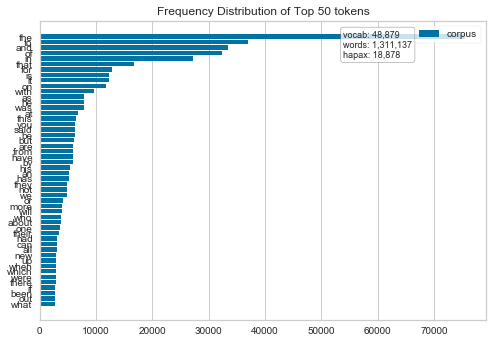

In [15]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(list(corpus.raw_data()))
visualizer = FreqDistVisualizer(features=vectorizer.get_feature_names())

visualizer.fit(docs)
visualizer.poof()

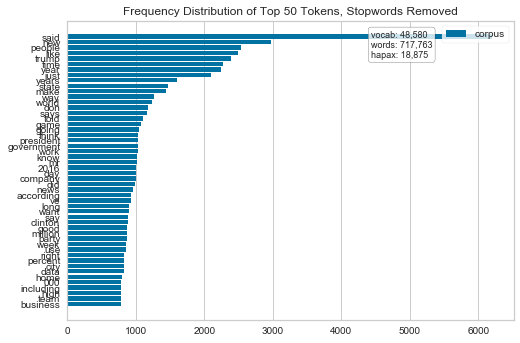

In [17]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(list(corpus.raw_data()))
visualizer = FreqDistVisualizer(
    features=vectorizer.get_feature_names(), 
    title="Frequency Distribution of Top 50 Tokens, Stopwords Removed"
)

visualizer.fit(docs)
visualizer.poof()

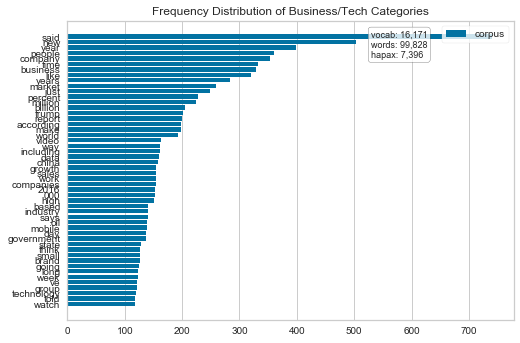

In [18]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(
    list(corpus.raw_data(categories=["business", "technology"]))
)
visualizer = FreqDistVisualizer(
    features=vectorizer.get_feature_names(), 
    title="Frequency Distribution of Business/Tech Categories"
)

visualizer.fit(docs)
visualizer.poof()

### Document Similarity 

Although we'll discuss vectorization in more detail during the machine learning part of the course, we can use document vectors to show groups of related documents by their contents.

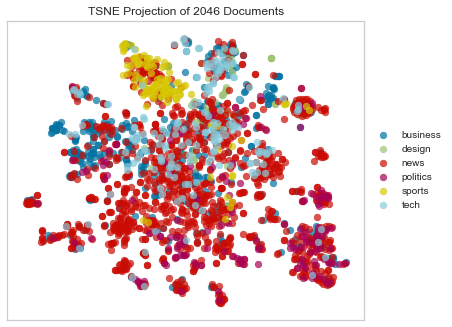

In [23]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

cats   = ["business", "design", "news", "politics", "sports", "tech"]
tfidf  = TfidfVectorizer()
docs   = tfidf.fit_transform(list(corpus.raw_data(categories=cats)))

tsne = TSNEVisualizer()
tsne.fit(docs, list(corpus.labels(categories=cats)))
tsne.poof()

## Word Forms and Search 

One of the most common forms of text analytics is search -- finding documents that contain specific concepts. However, a string matching search on even our preprocessed data will require additional normalization for case and multiple word forms. 

### Stemming 

The simplest (and most commonly used) word form normalization is _stemming_; simply chop off affixes to create a root stem whose representation is the word form. 

In [26]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
stemmer.stem("generously")

'gener'

In [27]:
from nltk.stem.snowball import SnowballStemmer

# Supported languages 
print(" ".join(SnowballStemmer.languages))

# Create an english stemmer 
stemmer = SnowballStemmer("english")
stemmer.stem("generously")

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


'generous'

### Lemmatization 

Rather than perform string manipulation, simply look up the root word by part of speech tag in a lexicon. This is far more accurate but incurs a performance penalty relative to the size of the corpus. 

In [51]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer


class Lemmatizer(object):
    
    tag_map = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def __call__(self, token, pos_tag):
        return self.lemmatize(token, pos_tag)

    def lemmatize(self, token, pos_tag):
        tag = self.tag_map.get(pos_tag[0], wn.NOUN)
        return self.lemmatizer.lemmatize(token, tag)


# Create the callable lemmatizer
lemmatize = Lemmatizer() 
lemmatize("waiting", "VB")

'wait'

In [49]:
sentence = list(word_tokenize("She sold seashells by the seashore on the 4th of July."))

print(" ".join([stemmer.stem(token) for token in sentence]))
print(" ".join([lemmatize(token, tag) for token, tag in pos_tag(sentence)]))

she sold seashel by the seashor on the 4th of juli .
She sell seashell by the seashore on the 4th of July .


### Search 

There are a lot of methods for search, but here we will look at a simple mechanism I use regularly in my research to quickly find context for a specific word or phrase: the `concordance()` method. 

In [53]:
from nltk.text import Text


class Search(object):
    
    def __init__(self, corpus):
        self.text = Text([
            lemmatize(token.lower(), tag) 
            for token, tag in corpus.tagged()
        ])
    
    def __call__(self, term, tag="NN"):
        return self.search(term, tag)
    
    def search(self, term, tag="NN"):
        term = lemmatize(term, tag)
        return self.text.concordance(term)

    
search = Search(corpus)

In [58]:
search("regulator")

Displaying 25 of 25 matches:
ch this video washington — federal regulator on thursday propose a set of priva
now , japan ’ s financial industry regulator hop relaxed rule on invest in fina
now , japan ’ s financial industry regulator hop relaxed rule on invest in fina
 supervision since june , when the regulator conduct an audit and instruct the 
ajor u . s . bank fail to persuade regulator they could go bankrupt without dis
 their so - call living will after regulator say the submission fail to satisfy
 their plan fell far short of what regulator deem acceptable . since then , the
se over the course of year be that regulator could eventually get authority to 
, because this mark the first time regulator have take the initial step to find
h bank receive a letter detail the regulator ’ expectation . the note to jpmorg
o promote an easy resolution , the regulator say . the living - will setback fo
 the eight u . s . institution the regulator respond to will be give until that
ccord to th

## N-Gram Analysis 

Now that we've broken apart our text into our smallest unit of work (tokens), we can start to build it back up into a computable form. The first, and simplest, method creates windows of context by aligning co-occuring words.

An N-Gram is a static group of N tokens, generated by sliding a fixed length window along the text, usually respecting sentence boundaries. For example, here is the generation of trigrams (N=3) on a sentence:

![N-Grams](figures/s1_ngrams.png)

In [59]:
from nltk import ngrams as nltk_ngrams
from functools import partial

LPAD_SYMBOL = "<s>"
RPAD_SYMBOL = "</s>"

nltk_ngrams = partial(nltk_ngrams,
    pad_right=True, pad_left=True,
    right_pad_symbol=RPAD_SYMBOL, 
    left_pad_symbol=LPAD_SYMBOL
)


def ngrams(text, n=3):
    for sent in sent_tokenize(text):
        sent = word_tokenize(sent)
        for ngram in nltk_ngrams(sent, n):
            yield ngram

In [61]:
text = """
The Capitals persevered in large part because of Eller’s effort against 
the Golden Knights, tying the series at a game apiece with the next 
two games in Washington. This was the first Stanley Cup finals game win
in franchise history.
"""

for trigram in ngrams(text):
    print(trigram)

('<s>', '<s>', 'The')
('<s>', 'The', 'Capitals')
('The', 'Capitals', 'persevered')
('Capitals', 'persevered', 'in')
('persevered', 'in', 'large')
('in', 'large', 'part')
('large', 'part', 'because')
('part', 'because', 'of')
('because', 'of', 'Eller')
('of', 'Eller', '’')
('Eller', '’', 's')
('’', 's', 'effort')
('s', 'effort', 'against')
('effort', 'against', 'the')
('against', 'the', 'Golden')
('the', 'Golden', 'Knights')
('Golden', 'Knights', ',')
('Knights', ',', 'tying')
(',', 'tying', 'the')
('tying', 'the', 'series')
('the', 'series', 'at')
('series', 'at', 'a')
('at', 'a', 'game')
('a', 'game', 'apiece')
('game', 'apiece', 'with')
('apiece', 'with', 'the')
('with', 'the', 'next')
('the', 'next', 'two')
('next', 'two', 'games')
('two', 'games', 'in')
('games', 'in', 'Washington')
('in', 'Washington', '.')
('Washington', '.', '</s>')
('.', '</s>', '</s>')
('<s>', '<s>', 'This')
('<s>', 'This', 'was')
('This', 'was', 'the')
('was', 'the', 'first')
('the', 'first', 'Stanley')
('fir

### Significant Collocations 

Obviously, some trigrams impart more information than others, e.g. `"Stanley Cup finals"` or `"tying the series"` vs. `"persevered in large"`. 

We can use association measures and statistical scoring methods to rank N-Grams by significance, further filtering and ranking the information retrieved from the corpus. 

In [64]:
from nltk.collocations import QuadgramCollocationFinder
from nltk.metrics.association import QuadgramAssocMeasures


# Extract quadgrams using the NLTK base collocation finder
cats   = ["business", "politics", "sports", "tech"]
ngrams = QuadgramCollocationFinder.from_words(corpus.words(categories=cats))

# Rank collocations by an association metric
scored = ngrams.score_ngrams(QuadgramAssocMeasures.likelihood_ratio)

[(("'", 's', '.', 'The'), 58543.4237454517), (('.', 'It', "'", 's'), 50516.65684363094), (("'", 's', 'in', 'the'), 49633.5229348087), (('New', 'York', "'", 's'), 48066.00150008884), (("'", 's', 'New', 'York'), 48006.30814192213), (("'", 's', ',', 'which'), 46942.84205595173), (('.', 'He', "'", 's'), 46816.14124398083), (('"', 'It', "'", 's'), 46423.16312167403), (('It', "'", 's', 'not'), 46299.71632252438), (('“', 'It', "'", 's'), 46063.60968745475)]


In [66]:
def print_scores(scored):
    table = [["N-Gram", "Score"]]
    for ngram, score in scored:
        table.append([" ".join(ngram), score])
    print(tabulate(table, headers="firstrow"))
    

# Print top 10 
print_scores(scored[:10])

N-Gram          Score
------------  -------
' s . The     58543.4
. It ' s      50516.7
' s in the    49633.5
New York ' s  48066
' s New York  48006.3
' s , which   46942.8
. He ' s      46816.1
" It ' s      46423.2
It ' s not    46299.7
“ It ' s      46063.6


In [72]:
# Print middle of scores 
print_scores(scored[len(scored)//2:len(scored)//2+10])

N-Gram                           Score
-----------------------------  -------
to have provided reasons       309.753
do not audit safety            309.752
with just the date             309.749
guy they had rated             309.747
the economy has improved       309.747
tech companies have committed  309.744
, Echo was prominently         309.741
not yet begun to               309.738
pick , guard was               309.737
claiming their civil rights    309.736


In [83]:
import nltk 
import string 

stopwords = frozenset(nltk.corpus.stopwords.words('english') + list(string.punctuation))

filtered_scored = [
    (ngram, score) for ngram, score in scored 
    if ngram[0].lower() not in stopwords
]

print("{} filtered quadgrams from {}\n".format(len(filtered_scored), len(scored)))
print_scores(filtered_scored[:20])

232964 filtered quadgrams from 439739

N-Gram              Score
----------------  -------
New York ' s      48066
“ It ' s          46063.6
Donald Trump ' s  45538.8
." It ' s         45244.6
.” It ' s         45222.3
“ it ' s          45200.8
). It ' s         45165.5
... It ' s        45106.4
.? It ' s         45088
2016 It ' s       45086.9
AMC It ' s        45080.5
navy It ' s       45080.5
¦ It ' s                   45077.5
Â It ' s          45076.7
Images It ' s     45072.4
ship It ' s       45071.9
-- It ' s         45068.9
think it ' s      45023.6
said it ' s       44930.2
whether it ' s    44929.4
